# **XAI-Methoden angewendet auf den Review (Aktivität-basiert) Datensatz**

Hier werden alle XAI Modell initialisiert und verglichen. 


## Packages installieren
 

In [1]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2

In [2]:
%%capture
#!pip install dive-into-graphs

In [3]:
%%capture
!git clone https://github.com/divelab/DIG.git
%cd DIG
!pip install .

In [4]:
%%capture
!pip install pm4py

In [9]:
# Hauptordner-Pfad
import torch
from pathlib import Path
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
%cd "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM" 

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [6]:
%load_ext autoreload
%autoreload 2

In [10]:
import torch
import joblib

# Module für das Preprocessing der verwendeten Datensätze
from preprocessing.loanApplication import *
from preprocessing.reviewSynthetic import *
from models.gcn3_neu import *

from torch_geometric.data.batch import Batch
from dig.xgraph.evaluation import XCollector
import tqdm as tqdm
import math

from dig.xgraph.method import PGExplainer
from dig.xgraph.method import GradCAM
from dig.xgraph.method import GNNExplainer
from utilities import RandomExplainer
from utilities_xai import train_pgexplainer, pgexplainer_run, gradcam_run, gnnexplainer_run, random_node_run, split_dataset_2_8, prediction_check
from train_gcn import load_gcn

from utilities import *

In [11]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Datensatz laden 

In [12]:
# Laden eines Vorverarbeiteten Datensatzes
dataset_name = "review_sn_f3_ohe_2"
dataset = torch.load(path / str("datasets/dataset_" + dataset_name))
feature = joblib.load("datasets/encoder_" + dataset_name + ".joblib")

In [13]:
ds_train, ds_test = split_dataset_2_8(dataset)

##Variablen

Hier sind alle Variablen zusammengefasst. Vor Ausführen der Datei können hier Konfigurationen vorgenommen werden

In [18]:

# ---------------------------Trainingsdatensatz ------------------------
test_len = 300

# ---------------------------Variablen Model---------------------------
hidden_channel = 100
input_dim = dataset.num_features
path_model = path / "models/"
model_name = dataset_name

# ---------------------------Variablen XAI Methoden---------------------------
#sparsity = 0.6    # Spärlichkeit: Wie viel Prozent des ursprünglichen Graphen aus der Erklärung ausgeschlossen werden soll
num_classes =  dataset.num_classes  # Anzahl der Klassen: 0: Review wurde angenommen, 1: Review wurde abgelehnt
# PGExpaleiner
pgexplainer_training = True # Soll der PGExplainer neu Trainiert werden (True für Ja)
path_pgexplainer =  path / "xai_methods/pgexplainer/trainiert" # Speicherort für Parameter des PGExplainer
pgexplainer_name = f"{dataset_name}/pgexplainer" # Speicherort für Parameter des PGExplainer

# ------------------------------Speicherort-------------------------------------
path_results = path / f"xai_results/{dataset_name}/"

#fast_test = ds_test[:test_len]

In [20]:
# Nur richtige Vorhersagen des Models beachten
model = load_gcn(model_name, input_dim, device, path)
fast_test = prediction_check(dataset, model, test_len, device)


## XAI Methoden

In [22]:
#-----------------------------------------------------------------xCollector----------------------------------------------------------------
# Listen in welchen xCollectoren für die vordefinierten Sparsity-Werte gespeichert werden
collector_list_subgraphX = []  
collector_list_gradcam = []
collector_list_gnnexplainer = []
collector_list_pgexplainer = []
collector_list_ggnn = []
collector_list_random_node = []
collector_list_random_edge = []

# Erstellen einer Liste von Sparsity-Werten 
steps = np.linspace(0.5,1,5,endpoint=False)
# Instantiieren der xCollectoren für unterschiedliche Sparsity-Werte 
for sparsity in steps:
  collector_list_subgraphX.append(XCollector())
  collector_list_gradcam.append(XCollector())
  collector_list_gnnexplainer.append(XCollector())
  collector_list_pgexplainer.append(XCollector())
  collector_list_ggnn.append(XCollector())
  collector_list_random_node.append(XCollector())
  collector_list_random_edge.append(XCollector())

### Random Node

In [ ]:
random_explainer = RandomExplainer()
model = load_gcn(dataset_name, input_dim, device, path)
print("--------------Random-Node--------------------")
for data in tqdm.tqdm(fast_test):  
  data = data.to(device)
  collector_list_random_node = random_node_run(data, collector_list_random_node, random_explainer, steps, model)

--------------Random-Node--------------------


100%|██████████| 300/300 [00:12<00:00, 23.83it/s]


###PGExplainer



In [16]:
param = {
    "lr": 0.05,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20}

In [23]:
model = load_gcn(dataset_name, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )
explainer_pge = train_pgexplainer(explainer_pge, False, ds_train, path, pgexplainer_name)
print("--------------PGExplainer--------------------")
for data in tqdm.tqdm(fast_test):  
  data = data.to(device) 
  collector_list_pgexplainer = pgexplainer_run(data, collector_list_pgexplainer, explainer_pge, steps)

--------------PGExplainer--------------------


100%|██████████| 300/300 [00:19<00:00, 15.04it/s]


In [24]:
sparsity_fidelity_pgexplainer = [x.fidelity for x in collector_list_pgexplainer]
sparsity_fidelity_inv_pgexplainer = [x.fidelity_inv for x in collector_list_pgexplainer]
sparsity_pgexplainer = [x.sparsity for x in collector_list_pgexplainer]

###GNN Explainer

In [27]:
param_gnnexplainer = {
    "lr": 0.001,    
    "epochs": 400
}

In [29]:
model = load_gcn(dataset_name, input_dim, device, path)
explainer_gnnexplainer = GNNExplainer(model, epochs=param_gnnexplainer["epochs"], lr=param_gnnexplainer["lr"], explain_graph=True) 
print("--------------GNN-Explainer--------------------")
for data in tqdm.tqdm(fast_test):  
  data = data.to(device)
  collector_list_gnnexplainer = gnnexplainer_run(data, collector_list_gnnexplainer, explainer_gnnexplainer, steps)



--------------GNN-Explainer--------------------


100%|██████████| 300/300 [1:20:15<00:00, 16.05s/it]


In [30]:
sparsity_fidelity_gnnexplainer = [x.fidelity for x in collector_list_gnnexplainer]
sparsity_fidelity_inv_gnnexplainer = [x.fidelity_inv for x in collector_list_gnnexplainer]
sparsity_gnnexplainer = [x.sparsity for x in collector_list_gnnexplainer]

### Grad-Cam

In [ ]:
model = load_gcn(dataset_name, input_dim, device, path)
explainer_grad_cam = GradCAM(model, explain_graph=True)
print("--------------Grad-Cam--------------------")
for data in tqdm.tqdm(fast_test):
  
  data = data.to(device)
  collector_list_gradcam = gradcam_run(data, collector_list_gradcam, explainer_grad_cam, steps)

--------------Grad-Cam--------------------


  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
100%|██████████| 300/300 [00:41<00:00,  7.26it/s]


## Visualisierung der Ergebnisse

In [14]:
from utilities_xai import load_eval_results, plot_results_prefix, plot_results_load

In [15]:
grad_cam_results, gnnexplainer_results, pgexplainer_results, ranodm_node_results = load_eval_results(path / f"xai_results/{dataset_name}")

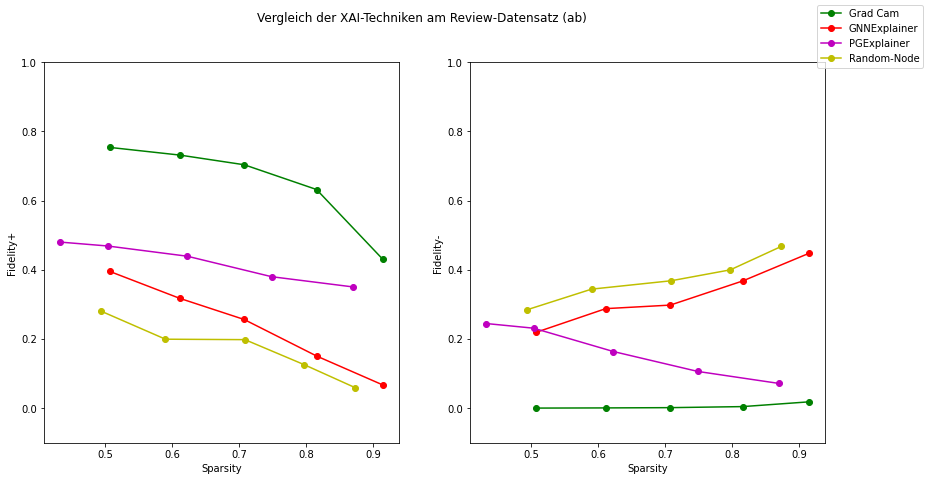

In [31]:
plot_results_load("Vergleich der XAI-Techniken am Review-Datensatz (ab)", path / f"xai_results/{dataset_name}", grad_cam_results[0], grad_cam_results[1], grad_cam_results[2], \
      sparsity_fidelity_gnnexplainer,sparsity_fidelity_inv_gnnexplainer,sparsity_gnnexplainer, \
        sparsity_fidelity_pgexplainer, sparsity_fidelity_inv_pgexplainer, sparsity_pgexplainer, \
          ranodm_node_results[0], ranodm_node_results[1], ranodm_node_results[2])

## Visuelle Darstellung der Erklär-Graphen einer Prozess-Instanz

Es wird jeweils ein Erklär-Graph für jede Klasse visualisiert

https://stackoverflow.com/questions/21895926/subplots-with-network-analysis-networkx


In [32]:
from utilities import plot_explanation
from torch_geometric.utils import to_networkx

In [33]:
param_pgexplainer = {
    "lr": 0.05,
    "coff_size": 0.01, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20}

param_gnnexplainer = {
    "lr": 0.001,    
    "epochs": 400
}


In [48]:
sparsity_vis = 0.7

# Model instantiieren
model = load_gcn(dataset_name, input_dim, device, path)

# Erstellen einer Liste von Sparsity-Werten 
steps = np.linspace(0.5,1,5,endpoint=False)

# ----------------------------------------------------------Instantiierung der Explainer-----------------------------------------------------------------------------------
# Als Input Variablen wird das trainierte GNN-Modell sowie die hidden Layer * 2 von diesem übergeben
model = load_gcn(dataset_name, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param_pgexplainer["epochs"], lr = param_pgexplainer["lr"], coff_ent = param_pgexplainer["coff_ent"] , coff_size = param_pgexplainer["coff_size"] , t0 = param_pgexplainer["t0"] , t1 = param_pgexplainer["t1"] )
explainer_pge = train_pgexplainer(explainer_pge, False, ds_train, path, pgexplainer_name)
#pge_utilities  = PGExplainer_Utilities()

explainer_gnnexplainer = GNNExplainer(model, epochs=param_gnnexplainer["epochs"], lr=param_gnnexplainer["lr"], explain_graph=True)  # Muss das training vorher durchgeführt werden?
explainer_grad_cam = GradCAM(model, explain_graph=True)


### Auswahl der zu visualisierenden Instanzen

Es wird eine Instanz jeder Klasse visualisiert

In [35]:
from utilities_xai import get_instanz_prediction_gcn

In [36]:
pred, out, y = get_instanz_prediction_gcn(dataset[:10], model, device)
df = pd.DataFrame()
df["real_y"] = y.tolist()
df["pred_y"] = pred.tolist()
df

,real_y,pred_y
0,0.0,0
1,1.0,1
2,0.0,0
3,0.0,0
4,0.0,0
5,1.0,1
6,1.0,1
7,1.0,1
8,0.0,0
9,0.0,0


### Betrachtete Prozess-Instanzen

In [37]:
from utilities_preprocessing import  GraphDatasetHelper

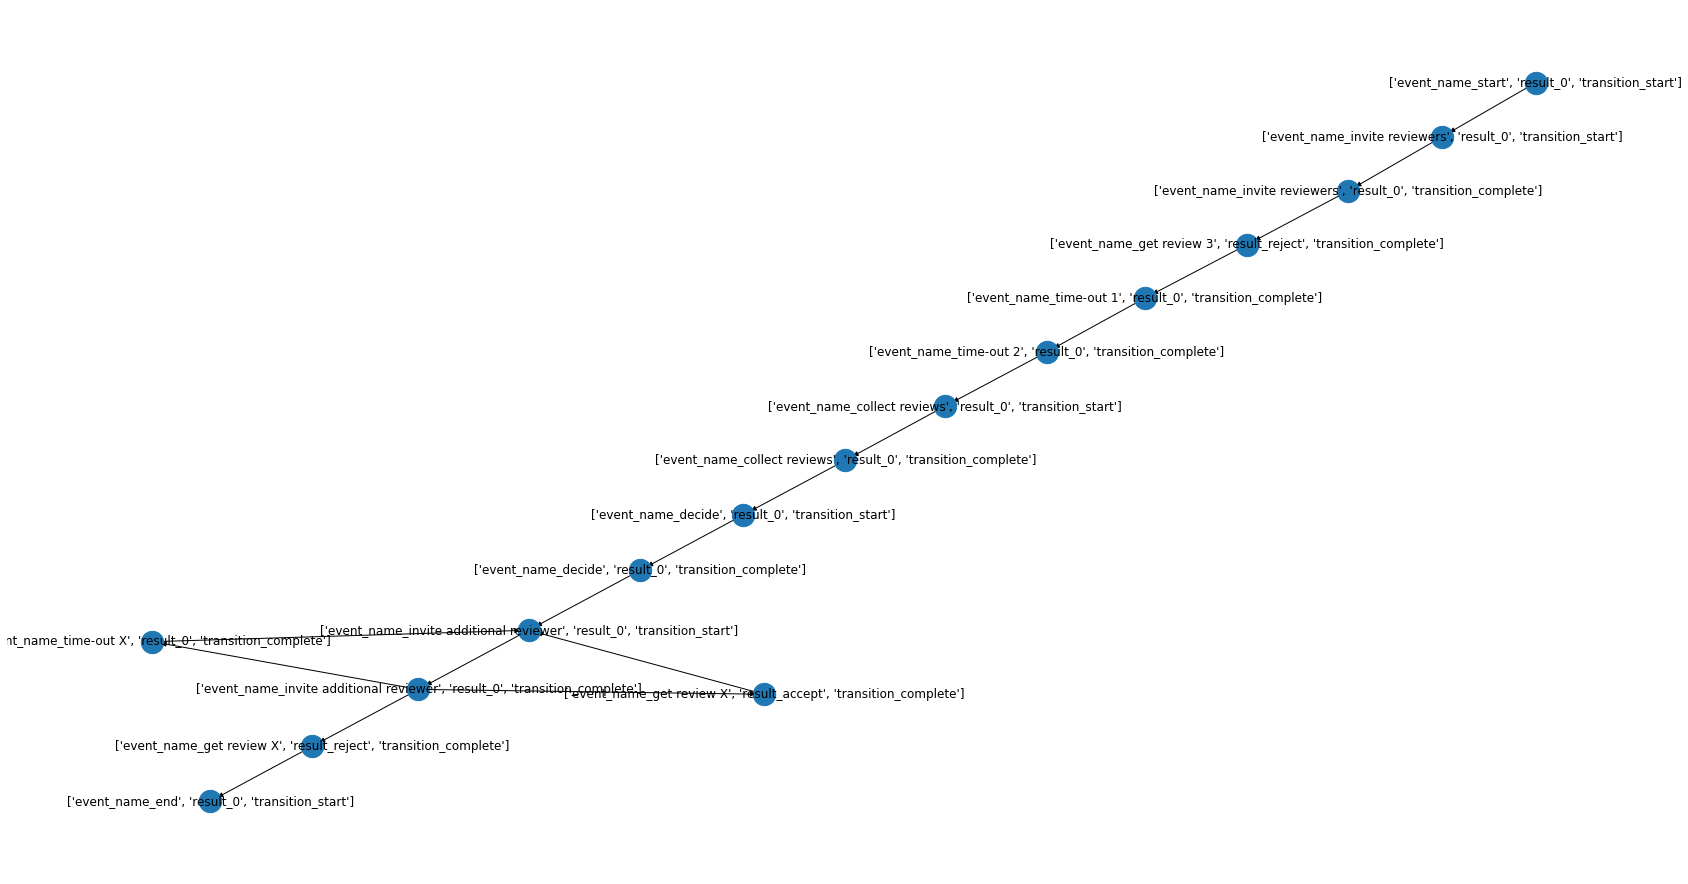

Label:  0.0


In [ ]:
# Klasse 0
data = dataset[3]
helper = GraphDatasetHelper(node_feature = feature)
helper.visualise_dataset(data)
print("Label: ", str(data.y.item()))

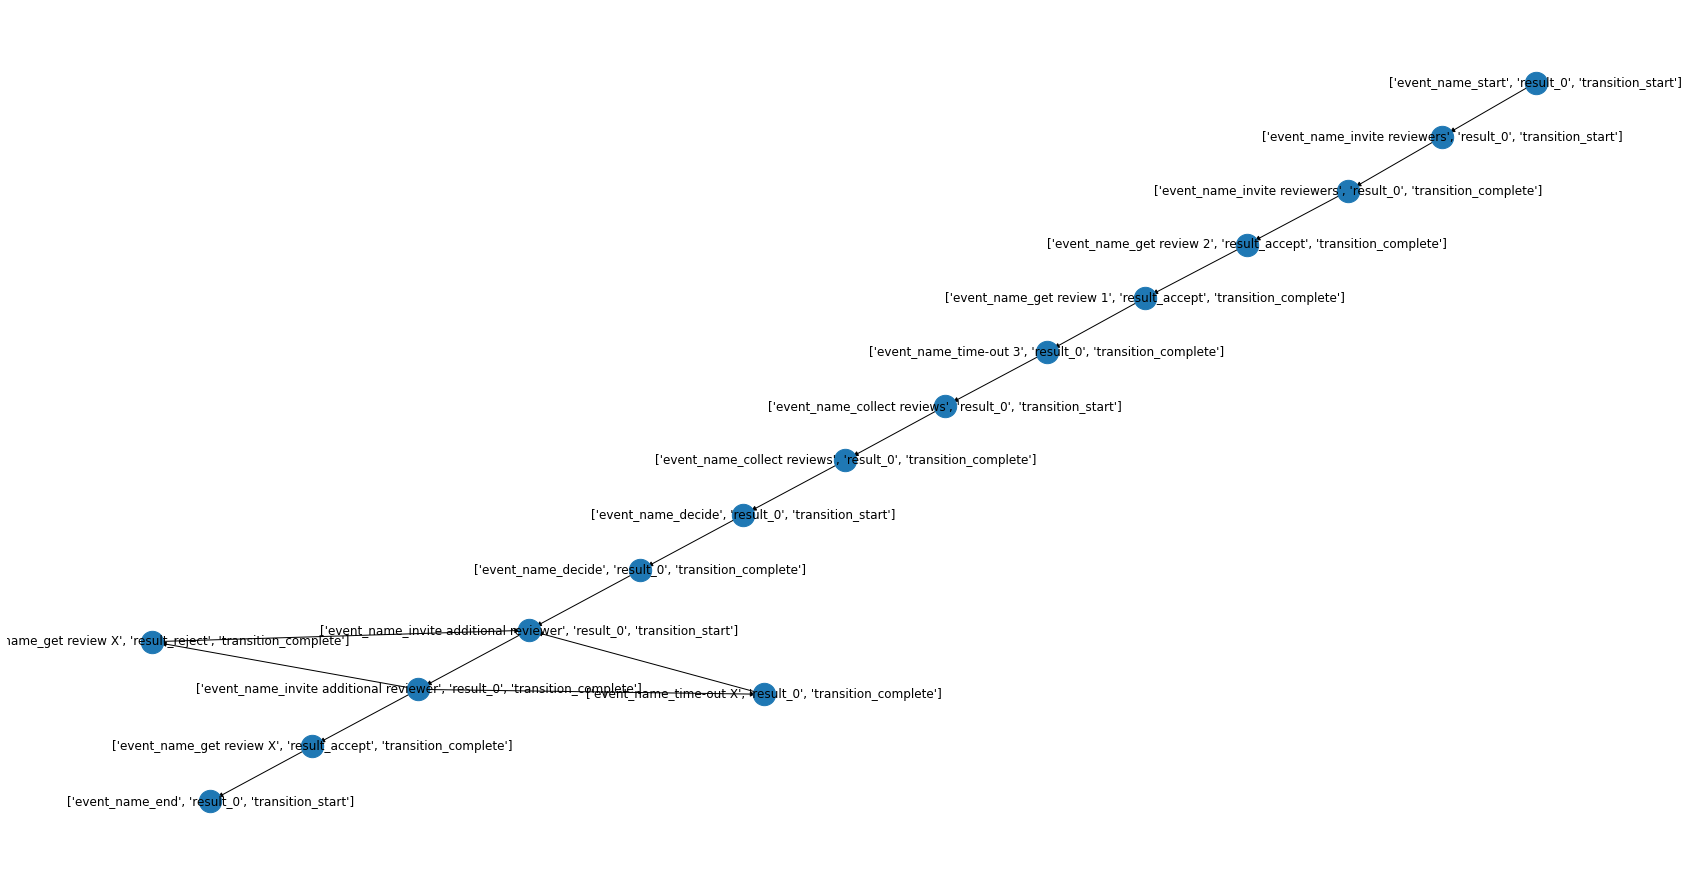

Label:  1.0


In [ ]:
# Klasse 1
data = dataset[5]
helper = GraphDatasetHelper(node_feature = feature)
helper.visualise_dataset(data)
print("Label: ", str(data.y.item()))

### Klasse 0 - Erklär-Graph

In [38]:
from utilities import plot_explanation_graphs

In [39]:
instance = dataset[3]

In [40]:
title = "Review Datensatz (ab) - Klasse: " + str(instance.y.item())

/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


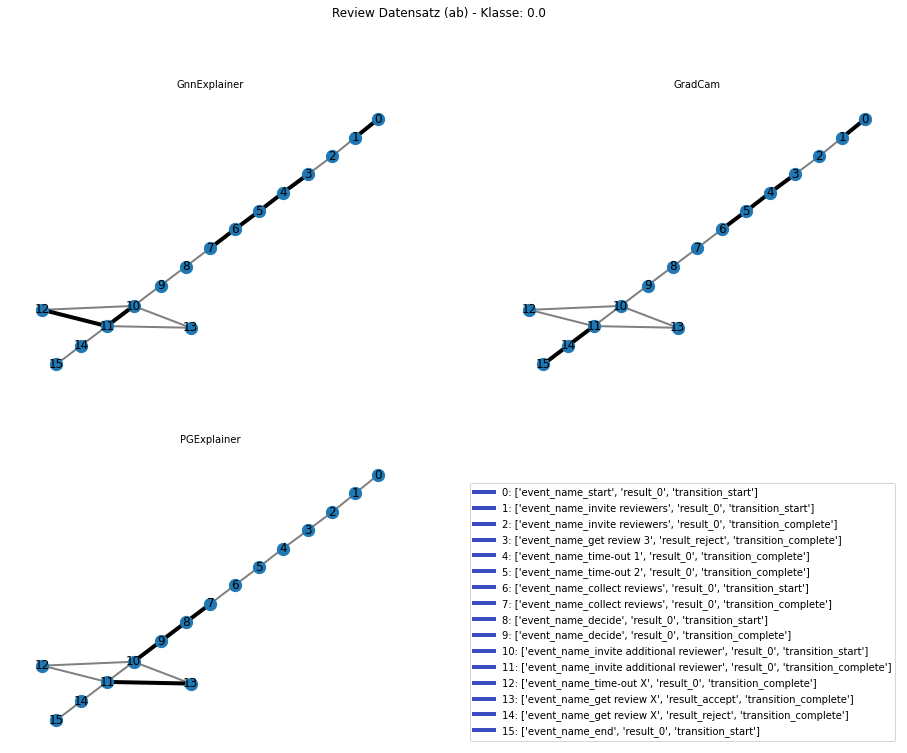

In [41]:
pge_explainer_preds, gnnexplainer_preds, gradcam_preds = plot_explanation_graphs(instance, feature, device, explainer_pge, explainer_gnnexplainer, explainer_grad_cam, title)

In [42]:
pge_explainer_preds

[{'masked': 0.10165688395500183,
  'maskout': 1.0,
  'origin': tensor([1.0000], device='cuda:0', grad_fn=<IndexBackward0>),
  'sparsity': 0.625}]

In [43]:
gnnexplainer_preds[0]

{'masked': 0.9990259408950806,
 'maskout': 0.01776878535747528,
 'origin': 0.9999988079071045,
 'sparsity': 0.7105263471603394,
 'zero': 0.6707846522331238}

In [44]:
gradcam_preds[0]

{'masked': 0.9999995231628418,
 'maskout': 0.010136347264051437,
 'origin': 0.9999988079071045,
 'sparsity': 0.7105263471603394,
 'zero': 0.6707846522331238}

### Klasse 1 - Erklär-Graph

In [45]:
instance = dataset[5]

In [46]:
title = "Review Datensatz (ab) - Klasse: " + str(instance.y.item())

/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index


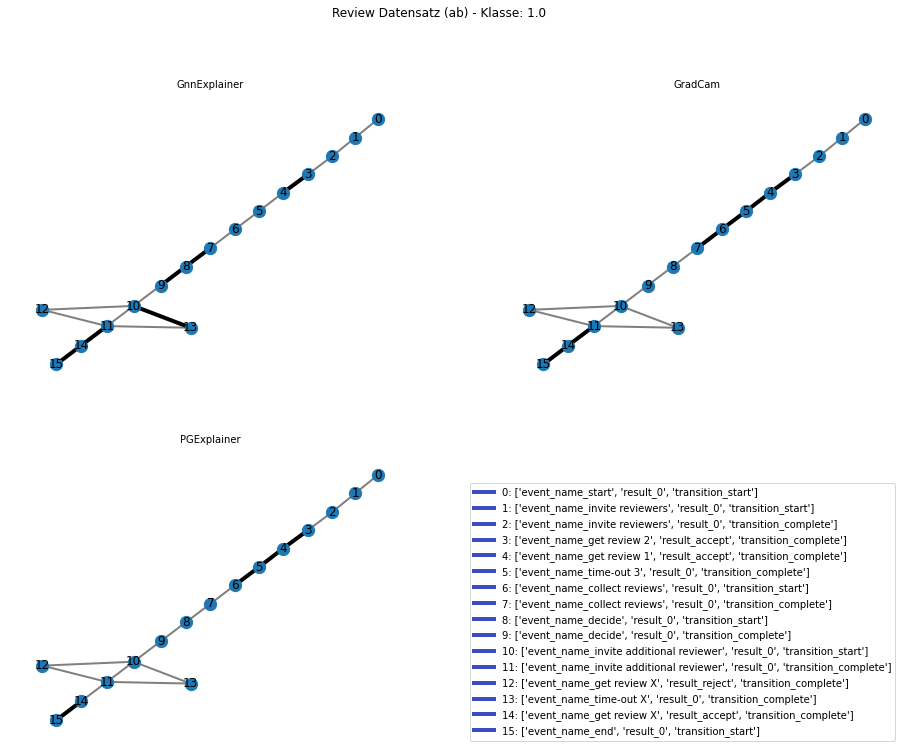

In [49]:
pge_explainer_preds, gnnexplainer_preds, gradcam_preds = plot_explanation_graphs(instance, feature, device, explainer_pge, explainer_gnnexplainer, explainer_grad_cam, title)

In [ ]:
pge_explainer_preds

[{'masked': 0.9999994039535522,
  'maskout': 0.0024808296002447605,
  'origin': tensor([1.0000], device='cuda:0', grad_fn=<IndexBackward0>),
  'sparsity': 0.625}]

In [50]:
gnnexplainer_preds[1]

{'masked': 0.9888209104537964,
 'maskout': 0.9789161086082458,
 'origin': 0.9999977350234985,
 'sparsity': 0.7105263471603394,
 'zero': 0.3292153775691986}

In [ ]:
gradcam_preds[1]

{'masked': 0.9999970197677612,
 'maskout': 0.010871175676584244,
 'origin': 0.9999977350234985,
 'sparsity': 0.7105263471603394,
 'zero': 0.3292153775691986}

Beispiel von: On Explainability of Graph Neural Networks via Subgraph Explorations


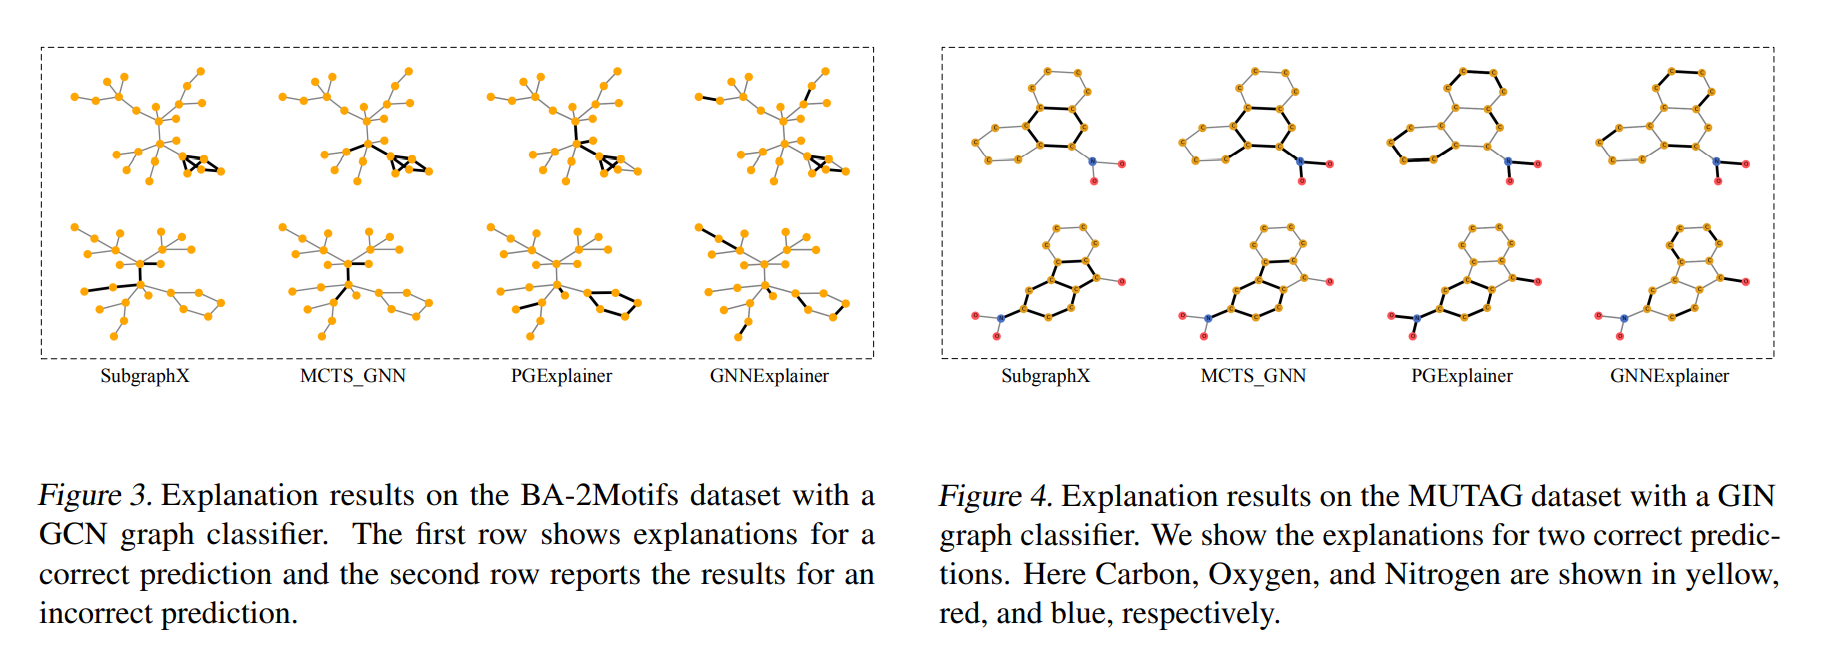